## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Name : Ezgi Ekin
###  Student ID : 2210356029


## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task :
* This assignment focuses on understanding and applying Convolutional Neural Networks (CNNs) and transfer learning techniques for image classification using the Animal-10 dataset. The first part involves building a CNN model from scratch using PyTorch. This includes preprocessing the dataset, designing and implementing a CNN architecture, training the model, and evaluating its performance using metrics such as accuracy, precision, recall, F1-score, and a confusion matrix. Additionally, different training parameters like learning rates and batch sizes will be tested to identify the best-performing model.

* Answer the questions like,
* What are the main components of a CNN architecture? :
* A CNN architecture consists of several key components that work together to process and classify images effectively. Convolutional layers apply filters to the input image, extracting important features such as edges and textures, with filter sizes varying based on the complexity of the model. Activation functions, like ReLU, introduce non-linearity to the network, enabling it to learn complex patterns. Pooling layers reduce the spatial dimensions of feature maps, making computations more efficient while helping the model focus on the most important features. Fully connected layers, located at the end of the network, take the flattened output from the convolutional layers and predict the image's class. Additionally, dropout layers are sometimes included to prevent overfitting by randomly disabling a fraction of neurons during training.
  
* Why we use this in image classification? :
* Unlike perceptron or linear models, where features are directly extracted from data, images require specialized processing to identify features. CNNs handle this by using filters and other components to automatically extract relevant features from images. Different filters and transformations can be applied depending on the characteristics of the data, making CNNs highly effective for image-based tasks.
  
* Why is experimenting with hyperparameters important? :
* Experimenting with hyperparameters like learning rates, batch sizes, and optimizer configurations is crucial to optimize the performance of a CNN. These parameters directly affect how the model learns during training.
  
* What are common challenges when training CNNs? :
* Training Convolutional Neural Networks can come with several challenges. One common issue is the vanishing or exploding gradient problem, where gradients become too small or too large during backpropagation, making it difficult to train deeper networks effectively. Overfitting is another challenge, where the model memorizes the training data instead of generalizing to new data, especially when there is limited training data available. Additionally, CNNs are computationally expensive and require powerful hardware, such as GPUs, to train efficiently. I suffered from the last one a lot since I bought computation units from Colab....
  
* Description of the dataset used for classification :
* The dataset used for classification is the Animals-10 Dataset. This dataset contains 4,500 labeled images of animals, distributed across 10 classes. Classes = {
    "Cane": "Dog",
    "Cavallo": "Horse",
    "Elefante": "Elephant",
    "Farfalla": "Butterfly",
    "Gallina": "Chicken",
    "Gatto": "Cat",
    "Mucca": "Cow",
    "Pecora": "Sheep",
    "Ragno": "Spider",
    "Scoiattolo": "Squirrel"
} The dataset includes a variety of image resolutions and is diverse in terms of poses, lighting, and backgrounds, making it a realistic dataset. For this assignment, the data is divided into training (3,000 images), validation (750 images), and testing (750 images) subsets.

### 1.2. Data Loading and Preprocessing (3 points)

In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, datasets
from torch.utils.data import Subset, DataLoader, Dataset
from collections import defaultdict
import matplotlib as plt
from PIL import Image
import os
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [6]:
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# CustomDataset class defines how to handle and transform the images and their labels.
# It allows loading images, resizing them to 256x256, and applying specified transformations.
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transformer=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')  # Ensures RGB format
        img = img.resize((256, 256))  # Standardize image size
        if self.transformer:
            img = self.transformer(img)  # Apply transformations if provided
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert label to tensor
        return img, label

    def set_transformer(self, transformer):
        self.transformer = transformer  # Dynamically set transformations if needed

# Dataset is loaded using ImageFolder, which assumes a specific directory structure.
# This extracts image paths and their labels while determining class names.
data_dir = "/content/drive/My Drive/Colab Notebooks/pa3_subset_animal"
dataset = datasets.ImageFolder(root=data_dir)
class_names = dataset.classes  # List of class names
print("Class Names:", class_names)

# Images and labels are grouped by class to facilitate balanced splitting for training, validation, and testing.
imgs_path = [sample[0] for sample in dataset.samples]
labels = [sample[1] for sample in dataset.samples]
images_by_class = {cls: [] for cls in range(len(class_names))}
for idx, (path, label) in enumerate(zip(imgs_path, labels)):
    images_by_class[label].append(idx)

# The dataset is split into training, validation, and test subsets with maximum samples per subset per class.
# Training gets up to 300 samples, validation 75, and testing 75 (if available).
train_indices, val_indices, test_indices = [], [], []
for cls, indices in images_by_class.items():
    random.shuffle(indices)
    n_train = min(300, len(indices))
    n_val = min(75, len(indices) - n_train)
    n_test = min(75, len(indices) - n_train - n_val)
    train_indices.extend(indices[:n_train])
    val_indices.extend(indices[n_train:n_train + n_val])
    test_indices.extend(indices[n_train + n_val:n_train + n_val + n_test])

# A simple transformation converts images to tensors.
raw_transform = transforms.Compose([
    transforms.ToTensor()
])

# CustomDataset objects are created for training, validation, and test datasets using the split indices.
train_dataset = CustomDataset([imgs_path[i] for i in train_indices], [labels[i] for i in train_indices], raw_transform)
val_dataset = CustomDataset([imgs_path[i] for i in val_indices], [labels[i] for i in val_indices], raw_transform)
test_dataset = CustomDataset([imgs_path[i] for i in test_indices], [labels[i] for i in test_indices], raw_transform)

# DataLoader is used to load training data in batches with optional parallel processing (num_workers) and optimized memory usage (pin_memory).
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

# Mean and standard deviation of the training dataset are calculated for normalization.
# This is done over all pixels in all channels (R, G, B) using batch-wise accumulation.
print("Calculating mean and standard deviation of the training dataset...")
sum_pixels = torch.zeros(3)
sum_squared_pixels = torch.zeros(3)
total_pixels = 0

for batch_imgs, _ in train_loader:
    sum_pixels += batch_imgs.sum(dim=(0, 2, 3))  # Sum pixel values for each channel
    sum_squared_pixels += (batch_imgs ** 2).sum(dim=(0, 2, 3))  # Sum squared pixel values
    total_pixels += batch_imgs.size(0) * batch_imgs.size(2) * batch_imgs.size(3)

# Mean and standard deviation are computed using accumulated sums and total pixel count.
mean = sum_pixels / total_pixels
std = torch.sqrt((sum_squared_pixels / total_pixels) - (mean ** 2))

print(f"Mean: {mean.tolist()}")
print(f"Standard Deviation: {std.tolist()}")


Class Names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Calculating mean and standard deviation of the training dataset...
Mean: [0.5094220042228699, 0.49372220039367676, 0.40673181414604187]
Standard Deviation: [0.2662599980831146, 0.2616821229457855, 0.27957257628440857]


In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Augment data by randomly flipping images horizontally
    transforms.RandomVerticalFlip(p=0.2),   # Augment data by occasionally flipping images vertically
    transforms.RandomRotation(15),          # Add random rotations to images within ±15 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Randomly adjust color properties
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Add slight translations to simulate variability
    transforms.ToTensor(),  # Convert images to tensor format for processing
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize pixel values using calculated dataset statistics
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Apply the same normalization as training for consistency
])

# Assign the defined transformations to the datasets
train_dataset.set_transformer(train_transform)  
val_dataset.set_transformer(val_test_transform) 
test_dataset.set_transformer(val_test_transform)  


In [9]:
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 3000
Validation set size: 750
Testing set size: 750


In [10]:
from collections import Counter

# Count occurrences of each class
class_counts1 = Counter(train_dataset.labels)
class_counts2 = Counter(val_dataset.labels)
class_counts3 = Counter(test_dataset.labels)

# Map the class indices back to class names for better readability
class_counts_readable1 = {class_names[idx]: count for idx, count in class_counts1.items()}
class_counts_readable2 = {class_names[idx]: count for idx, count in class_counts2.items()}
class_counts_readable3 = {class_names[idx]: count for idx, count in class_counts3.items()}

print("Class Counts (Training):", class_counts_readable1)  # Class counts with names
print("Class Counts (Validation):", class_counts_readable2)  # Class counts with names
print("Class Counts (Test):", class_counts_readable3)  # Class counts with names

Class Counts (Training): {'cane': 300, 'cavallo': 300, 'elefante': 300, 'farfalla': 300, 'gallina': 300, 'gatto': 300, 'mucca': 300, 'pecora': 300, 'ragno': 300, 'scoiattolo': 300}
Class Counts (Validation): {'cane': 75, 'cavallo': 75, 'elefante': 75, 'farfalla': 75, 'gallina': 75, 'gatto': 75, 'mucca': 75, 'pecora': 75, 'ragno': 75, 'scoiattolo': 75}
Class Counts (Test): {'cane': 75, 'cavallo': 75, 'elefante': 75, 'farfalla': 75, 'gallina': 75, 'gatto': 75, 'mucca': 75, 'pecora': 75, 'ragno': 75, 'scoiattolo': 75}


### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture :
* The architecture of this model was refined through several iterations to address challenges related to underfitting, overfitting, and overall performance, while also leveraging transformations and activation functions effectively. Initially, I started with 4 convolutional layers and used ReLU as the activation function. However, the model struggled to perform well, achieving only 55% validation accuracy. This suggested that the network was too shallow to capture the complexities of the data, even though standard transformations like resizing, normalization, and data augmentation (random rotations, flips, and color jittering) were applied.

* To improve performance, I increased the number of filters in the convolutional layers, added a fifth convolutional layer, and increased the number of neurons in the fully connected layers. Although these changes enhanced training accuracy, the model began to overfit, achieving 66% validation accuracy while performing significantly better on the training data. To mitigate this, I incorporated weight decay and dropout layers. However, the excessive number of filters and fully connected neurons caused the model to over-parameterize for the dataset size, leading to a trade-off between overfitting and underfitting.

* During this process, I also noticed that using ReLU as the activation function resulted in some neurons becoming inactive (dying ReLU problem), especially in deeper layers with higher filter counts. To address this, I switched to Leaky ReLU, which allows small gradient flows for negative inputs, preventing neurons from becoming inactive. This change improved the model's ability to learn from the data and contributed to better overall convergence.

* Finally, I reduced the number of filters and neurons in the fully connected layers, balancing the model's capacity with the dataset size. I also increased the dropout rate to handle residual overfitting, as further increasing weight decay led to underfitting. These adjustments, along with Leaky ReLU and the applied transformations, helped achieve a model that generalizes effectively without overfitting or underfitting significantly.

* Explain your choice of activation functions :
* The Leaky ReLU activation function is used in this network to prevent the dying ReLU problem by allowing a small gradient for negative inputs, ensuring neurons stay active. It provides stable gradient flow, reducing the risk of vanishing gradients in deeper networks, and often achieves faster convergence and better accuracy in image tasks. Leaky ReLU is applied after batch normalization in convolutional layers for effective non-linearity and stable training.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv(nn.Module):
    def __init__(self, num_classes=10):
        super(Conv, self).__init__()
        
        # Define the convolutional layers with increasing channel sizes to extract hierarchical features.
        # Each convolutional layer is followed by a batch normalization layer to stabilize training.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        # Define a max pooling layer to reduce spatial dimensions after each convolutional operation.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Apply dropout for regularization to prevent overfitting in fully connected layers.
        self.dropout = nn.Dropout(p=0.5)

        # Flatten the final feature maps into a 1D vector for fully connected layers.
        # The flatten size is calculated based on the input size (256x256) and 5 pooling operations.
        self.flatten_size = 256 * 8 * 8

        # Define fully connected layers for classification.
        # The first layer reduces the feature dimension, and the second outputs the class probabilities.
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Pass input through the convolutional layers with batch normalization, activation, and pooling.
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))

        # Flatten the spatial dimensions for the fully connected layers.
        x = x.view(x.size(0), -1)

        # Pass through the fully connected layers, applying dropout after the first layer.
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Return the output logits for classification.
        return x


### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms. :
* For my multi-class classification problem, I chose CrossEntropyLoss because it naturally combines softmax and log loss, helping the model assign high probabilities to the correct classes while minimizing errors for incorrect predictions. It’s the most intuitive and effective loss function for this kind of task. I went with the Adam optimizer because it adapts the learning rates dynamically for each parameter, making training faster and more stable. I did try using SGD, and while it showed some improvements, it was just too slow to converge, especially with my chosen epochs and batch sizes. Adam gave me the balance I needed between efficiency and performance.

In [12]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)
criterion ="CrossEntropyLoss"

## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
optimizer = "Adam"

# Define hyperparameters to test
learning_rates = [0.00005, 0.0001, 0.001]
batch_sizes = [40,80]
epochs =  150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
def train(train_loader, net, criterion, optimizer):
    net.train()
    losses, preds, labels = [], [], []

    for batch in train_loader:
        data, label = batch
        data = data.to(device)
        label = label.to(device)

        labels.append(label.cpu().numpy())  # Collect labels

        # Forward pass
        y_pred = net(data)
        _, pred = torch.max(y_pred, axis=1)
        preds.append(pred.cpu().numpy())  # Collect predictions

        # Compute loss
        loss = criterion(y_pred, label)
        losses.append(loss.detach().item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Ensure concatenation of arrays
    labels = np.concatenate(labels, axis=0)  
    preds = np.concatenate(preds, axis=0)   
    return losses, labels, preds


def val(val_loader, net, criterion):
    net.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():  # No gradient computation for validation
        for batch in val_loader:
            data, label = batch
            data = data.to(device)
            label = label.to(device)

            y_pred = net(data)
            _, pred = torch.max(y_pred, axis=1)

            preds.append(pred.cpu().numpy())
            labels.append(label.cpu().numpy())

            loss = criterion(y_pred, label)
            losses.append(loss.detach().item())

    # Convert predictions and labels to numpy arrays
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    return losses, labels, preds

### 1.5 Train and Validate the CNN model (9 points)

In [14]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# This function handles training and validation for a single configuration of hyperparameters.
# It includes dataset loading, training, validation, and model saving for the best validation performance.

def train_and_evaluate_single_config(
        lr, batch_size, opt_type, criterion, train_dataset, val_dataset, Conv, device, epochs, model_save_path
):
    print(f"\nTesting LR: {lr}, Batch Size: {batch_size}")

    # Set up data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    # Initialize the model and move it to the specified device
    model = Conv().to(device)

    # Define the loss function
    if criterion == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss().to(device)

    # Select the optimizer based on the input parameter
    if opt_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Variables to store metrics
    avg_train_losses, avg_val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0
    best_model_state = None

    # Training loop across specified epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training step: Forward pass, compute loss, backward pass, and update parameters
        train_losses, train_labels, train_preds = train(train_loader, model, criterion, optimizer)
        train_losses = np.array(train_losses)
        train_labels = np.array(train_labels).ravel()
        train_preds = np.array(train_preds).ravel()
        train_acc = accuracy_score(train_labels, train_preds)

        avg_train_losses.append(train_losses.mean())
        train_accuracies.append(train_acc)

        print(f"  Train Loss: {train_losses.mean():.4f}, Accuracy: {train_acc * 100:.2f}%")

        # Validation step: Evaluate model performance on the validation dataset
        val_losses, val_labels, val_preds = val(val_loader, model, criterion)
        val_losses = np.array(val_losses)
        val_labels = np.array(val_labels).ravel()
        val_preds = np.array(val_preds).ravel()
        val_acc = accuracy_score(val_labels, val_preds)

        avg_val_losses.append(val_losses.mean())
        val_accuracies.append(val_acc)

        print(f"  Validation Loss: {val_losses.mean():.4f}, Accuracy: {val_acc * 100:.2f}%")

        # Save the model if the current epoch has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()  # Save the model state dictionary
            torch.save(model.state_dict(), model_save_path)

    # Return metrics and the best validation accuracy
    metrics = [avg_train_losses, avg_val_losses, train_accuracies, val_accuracies]
    return metrics, best_val_acc


In [15]:
first_model_metrics= train_and_evaluate_single_config(learning_rates[0], batch_sizes[0], optimizer ,criterion, train_dataset, val_dataset, Conv, device, epochs, "first_model.pth")
second_model_metrics = train_and_evaluate_single_config(learning_rates[1], batch_sizes[0], optimizer ,criterion, train_dataset, val_dataset, Conv, device, epochs, "second_model.pth")
third_model_metrics = train_and_evaluate_single_config(learning_rates[2], batch_sizes[0], optimizer ,criterion, train_dataset, val_dataset, Conv, device, epochs, "third_model.pth")
fourth_model_metrics= train_and_evaluate_single_config(learning_rates[0], batch_sizes[1], optimizer ,criterion, train_dataset, val_dataset, Conv, device, epochs, "fourth_model.pth")
fifth_model_metrics = train_and_evaluate_single_config(learning_rates[1], batch_sizes[1], optimizer ,criterion, train_dataset, val_dataset, Conv, device, epochs, "fifth_model.pth")
sixth_model_metrics = train_and_evaluate_single_config(learning_rates[2], batch_sizes[1], optimizer ,criterion, train_dataset, val_dataset, Conv, device, epochs, "sixth_model.pth")



Testing LR: 5e-05, Batch Size: 40
Epoch 1/150
  Train Loss: 2.2716, Accuracy: 17.07%
  Validation Loss: 2.0343, Accuracy: 30.93%
Epoch 2/150
  Train Loss: 2.1281, Accuracy: 24.00%
  Validation Loss: 1.9450, Accuracy: 33.73%
Epoch 3/150
  Train Loss: 2.0589, Accuracy: 25.93%
  Validation Loss: 1.8715, Accuracy: 33.73%
Epoch 4/150
  Train Loss: 2.0114, Accuracy: 28.67%
  Validation Loss: 1.8381, Accuracy: 34.13%
Epoch 5/150
  Train Loss: 1.9519, Accuracy: 29.70%
  Validation Loss: 1.7120, Accuracy: 41.87%
Epoch 6/150
  Train Loss: 1.9045, Accuracy: 31.73%
  Validation Loss: 1.6637, Accuracy: 40.00%
Epoch 7/150
  Train Loss: 1.8495, Accuracy: 33.30%
  Validation Loss: 1.6107, Accuracy: 45.60%
Epoch 8/150
  Train Loss: 1.8079, Accuracy: 35.17%
  Validation Loss: 1.5764, Accuracy: 43.33%
Epoch 9/150
  Train Loss: 1.7948, Accuracy: 36.03%
  Validation Loss: 1.5747, Accuracy: 44.93%
Epoch 10/150
  Train Loss: 1.7689, Accuracy: 37.67%
  Validation Loss: 1.5446, Accuracy: 44.80%
Epoch 11/150
 

In [16]:
print(first_model_metrics[1])
print(second_model_metrics[1])
print(third_model_metrics[1])
print(fourth_model_metrics[1])
print(fifth_model_metrics[1])
print(sixth_model_metrics[1])


0.7026666666666667
0.7226666666666667
0.74
0.6746666666666666
0.6906666666666667
0.7306666666666667


In [17]:
# Load the best model
cnn_best = Conv().to(device)  # Ensure `Conv` matches the training architecture
cnn_best.load_state_dict(torch.load("third_model.pth"))

<ipython-input-17-cdf93ad88d14>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_best.load_state_dict(torch.load("third_model.pth"))


<All keys matched successfully>

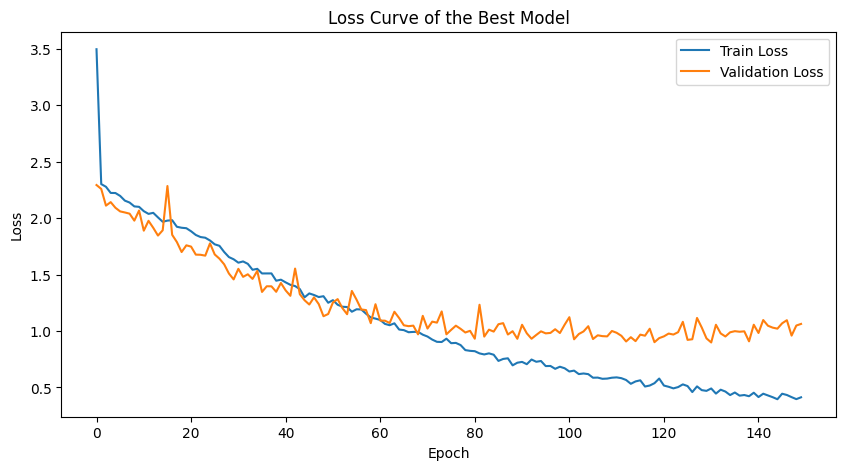

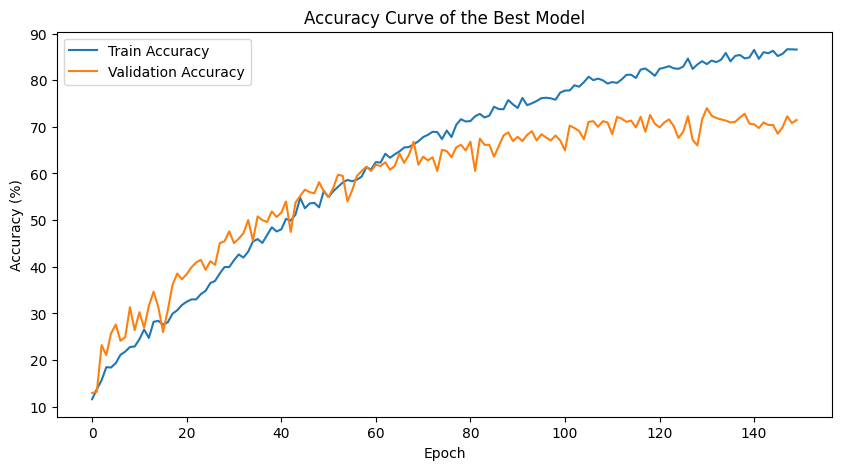

In [18]:
# Visualize loss and accuracy trends for the best model
plt.figure(figsize=(10, 5))
plt.plot(third_model_metrics[0][0], label="Train Loss")
plt.plot(third_model_metrics[0][1], label="Validation Loss")
plt.title("Loss Curve of the Best Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot([metrics * 100 for metrics in third_model_metrics[0][2]], label="Train Accuracy")
plt.plot([metrics * 100 for metrics in third_model_metrics[0][3]], label="Validation Accuracy")
plt.title("Accuracy Curve of the Best Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Mention about, why did you choose your learning rate and batch size? :
* Learning Rate: A learning rate of 0.001 was chosen as it ensured effective convergence without oscillations or divergence. Smaller rates (0.00005, 0.0001) slowed training, while higher rates risked instability.

* Batch Size: A batch size of 40 provided stable gradient updates, better generalization, and faster convergence compared to 80, while requiring fewer computational resources.

### 1.6 Evaluate the trained model on the test set (6 points)


Classification Report:
              precision    recall  f1-score   support

        cane       0.46      0.60      0.52        75
     cavallo       0.72      0.44      0.55        75
    elefante       0.82      0.85      0.84        75
    farfalla       0.86      0.88      0.87        75
     gallina       0.84      0.68      0.75        75
       gatto       0.62      0.88      0.73        75
       mucca       0.69      0.65      0.67        75
      pecora       0.66      0.61      0.63        75
       ragno       0.84      0.77      0.81        75
  scoiattolo       0.71      0.69      0.70        75

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750

Test Accuracy: 70.67%


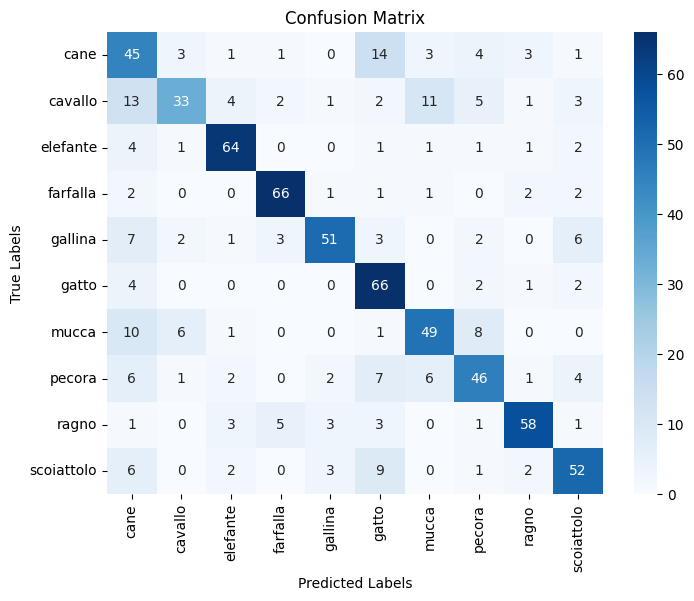

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to evaluate the trained model on the test dataset.
# It returns predictions and true labels for further analysis.
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []  # To store all predictions
    all_labels = []  # To store all ground truth labels

    with torch.no_grad():  # Disable gradient computation for testing
        for images, labels in test_loader:
            # Move images and labels to the specified device (CPU/GPU)
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass through the model
            outputs = model(images)
            
            # Get the predicted class with the highest probability
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Evaluate the best-trained model using the test loader
all_preds, all_labels = test_model(cnn_best, test_loader, device)

# Calculate and display classification metrics (accuracy, precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

accuracy = accuracy_score(all_labels, all_preds)  # Calculate overall test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate and visualize the confusion matrix to analyze class-wise performance
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set

Best Performance: The model performed particularly well on classes such as "farfalla" (F1-score: 0.87) and "elefante" (F1-score: 0.84), showing high precision and recall.
Weakest Performance: Lower performance was observed in classes like "cane" (F1-score: 0.52) and "cavallo" (F1-score: 0.55), primarily due to lower recall and higher misclassification rates.
Misclassifications:
"Cane" was often misclassified as "gatto".
"Cavallo" was often misclassified as "cane" and "mucca".

* Discuss any challenges encountered during training and potential areas for improvement :

 Balancing Underfitting and Overfitting:
One of the most challenging aspects was navigating between underfitting and overfitting zones. Determining the right level of model complexity, including the number of convolutional layers, pool layers, and dropout rates, required extensive experimentation.
As this was my first experience with this model architecture, understanding how convolutional and pooling layers extract features and how dropout layers prevent overfitting was a steep learning curve. This lack of familiarity led to trial-and-error adjustments.

 Hyperparameter Tuning:
Choosing the optimal number of convolutional layers and the right hyperparameters, such as learning rate and batch size, was a challenge. Often, changes did not yield significant improvements, adding to the time and complexity.

Potential improvements:
Implementing early stopping to halt training when the validation loss stops improving can reduce unnecessary computational costs and enable returning to earlier checkpoints. Additionally, incorporating more data augmentation techniques and applying additional regularization methods can enhance the model's ability to generalize to unseen data.

* Reflect on the overall effectiveness of the chosen CNN architecture and training approach :
 The CNN architecture had a good balance between depth and complexity, but fine-tuning the number of convolutional and pooling layers was challenging. While the model performed well on certain classes, misclassifications in others (e.g., "cane" and "cavallo") suggest that adjustments to the depth or receptive fields could improve performance. Dropout layers helped reduce overfitting to some extent, but there is still room to improve generalization with better regularization techniques. The model showed potential, but its high computational demands and sensitivity to hyperparameter changes suggest that it is not yet fully optimized for efficient training and inference. Long training times and frequent adjustments to hyperparameters reduced efficiency. Overall, the CNN architecture and training approach were moderately effective, achieving decent accuracy while revealing areas for improvement. The process demonstrated a solid understanding of deep learning principles.

### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.
 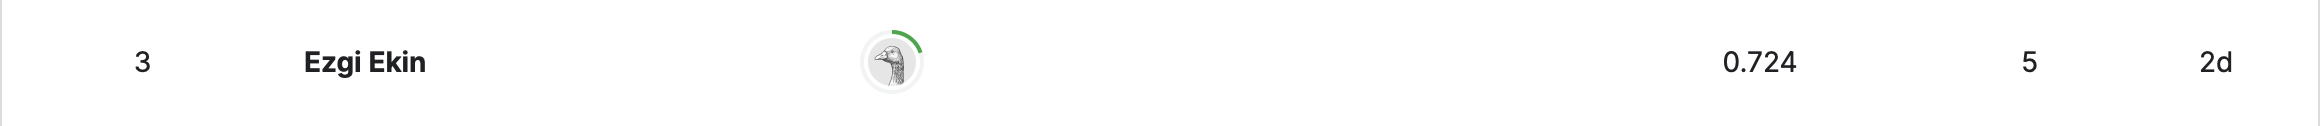
* The Kaggle test result shows a score of 0.724 for the CNN model, indicating solid performance with some room for improvement. This score demonstrates that the model is effective at classifying the dataset, achieving over 70% accuracy. Additionally, the similarity between the Kaggle result and my own test results confirms that the model generalizes well to unseen data, validating its robustness and reliability.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task :
  In second part, we will use pre-trained models (ResNet-18 and MobileNet) and fine-tune their layers to classify the same dataset. Different levels of fine-tuning will be applied, and their performance will be evaluated. We will then compare the results of the CNN model we built from scratch with the pre-trained models, focusing on their accuracy, efficiency, and resource usage.
  
 Answer the questions like :

* What is fine-tuning?

 Fine-tuning is a machine learning technique where a pre-trained model is further trained on a specific dataset or task to optimize its performance for that particular application.

* Why should we do this?

Training a model from scratch on large datasets takes a lot of time and computational power. Pre-trained models, however, already come with a strong foundation of learned features. This allows us to skip the initial training and focus on adjusting the model for our specific task.
Fine-tuning uses the knowledge from pre-trained models to achieve high performance, even when we have limited data. It also builds on transfer learning, where a model trained for one task (like general image classification) can be adapted to another, more specific task. Since pre-trained models already capture general patterns, fine-tuning reduces the risk of overfitting, making the model more efficient and accurate for the target application.

* Why do we freeze the rest and train only last layers?
* The early layers of a pre-trained model focus on learning general features like edges, textures, and basic patterns that are common to many tasks. The later layers, however, are designed to learn task-specific features. By training only the last layers, the model can adapt to the new dataset and task without altering the general features already learned in the earlier layers.
If we retrain the whole model, especially with a small dataset, we risk overwriting the useful features gained during pre-training. Freezing the earlier layers also makes fine-tuning simpler and more stable, as the optimizer only needs to adjust the weights of the last layers. This helps the model converge more easily on the new task.

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [21]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.
import torch
import torchvision.models as models
from torchsummary import summary

# Load the pre-trained ResNet18 model
resnet18_model = models.resnet18(pretrained=True)

# Check if GPU is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
resnet18_model = resnet18_model.to(device)

# Print the model architecture
print(resnet18_model)
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=40, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=12, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [22]:
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the animal-10 image dataset. (base model)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load ResNet-18 and freeze all layers
base_model = models.resnet18(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

# Replace the final FC layer
num_classes = 10  # Animal-10 dataset has 10 classes
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

# Ensure the new FC layer is trainable
for param in base_model.fc.parameters():
    param.requires_grad = True

# Set device, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)
criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(base_model.fc.parameters(), lr=0.001)




In [23]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)

# Load ResNet-18 and freeze all layers initially
second_model = models.resnet18(pretrained=True)
for param in second_model.parameters():
    param.requires_grad = False

# Replace the final FC layer
second_model.fc = nn.Linear(second_model.fc.in_features, num_classes)

# Unfreeze convolutional layers 3 and 4 and the final FC layer
for name, param in second_model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

# Move the model to the device
second_model = second_model.to(device)

# Define optimizer for trainable parameters
criterion_second = nn.CrossEntropyLoss()
optimizer_second = optim.Adam(filter(lambda p: p.requires_grad, second_model.parameters()), lr=0.0005)




In [24]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)

# Load ResNet-18 and unfreeze all layers
third_model = models.resnet18(pretrained=True)
for param in third_model.parameters():
    param.requires_grad = True

# Replace the final FC layer
third_model.fc = nn.Linear(third_model.fc.in_features, num_classes)

# Move the model to the device
third_model = third_model.to(device)

# Define optimizer for all parameters
criterion_third = nn.CrossEntropyLoss()
optimizer_third = optim.Adam(third_model.parameters(), lr=0.0001)



In [25]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

best_accuracy = 0.0
resnet18_best_model_path = "resnet18_best_model.pth"

mobilenet_best_model_path = "mobilenet_best_model.pth"

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs, device, save_path,):
    global best_accuracy

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0.0
    best_val_loss = float('inf')  # To track the best validation loss

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

        # Save the best model for this specific model
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1]
            best_val_loss = val_losses[-1]

        # Update the global best model
        if val_accuracies[-1] > best_accuracy:
            best_accuracy = val_accuracies[-1]
            torch.save(model.state_dict(), save_path)

    return train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss, best_val_accuracy


In [27]:
# Train models
print("Training Base Model...")
base_model_train_results = train_model(base_model, optimizer_base, criterion_base, train_loader, val_loader, 30, device, resnet18_best_model_path)

print("Training Second Model...")
second_model_train_results = train_model(second_model, optimizer_second, criterion_second, train_loader, val_loader, 30, device, resnet18_best_model_path)

print("Training Third Model...")
third_model_train_results = train_model(third_model, optimizer_third, criterion_third, train_loader, val_loader, 30, device, resnet18_best_model_path)

print(base_model_train_results[5])
print(second_model_train_results[5])
print(third_model_train_results[5])


Training Base Model...


Epoch 1/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.21it/s]


Epoch 1/30:
  Train Loss: 0.3347, Train Accuracy: 89.27%
  Val Loss: 0.1730, Val Accuracy: 94.27%


Epoch 2/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


Epoch 2/30:
  Train Loss: 0.3528, Train Accuracy: 88.43%
  Val Loss: 0.1722, Val Accuracy: 94.40%


Epoch 3/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.38it/s]


Epoch 3/30:
  Train Loss: 0.3478, Train Accuracy: 88.67%
  Val Loss: 0.1678, Val Accuracy: 94.40%


Epoch 4/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.56it/s]


Epoch 4/30:
  Train Loss: 0.3487, Train Accuracy: 88.00%
  Val Loss: 0.1752, Val Accuracy: 94.13%


Epoch 5/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


Epoch 5/30:
  Train Loss: 0.3436, Train Accuracy: 88.67%
  Val Loss: 0.1671, Val Accuracy: 94.13%


Epoch 6/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]


Epoch 6/30:
  Train Loss: 0.3461, Train Accuracy: 89.10%
  Val Loss: 0.1701, Val Accuracy: 94.93%


Epoch 7/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.60it/s]


Epoch 7/30:
  Train Loss: 0.3541, Train Accuracy: 88.23%
  Val Loss: 0.1742, Val Accuracy: 94.53%


Epoch 8/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.50it/s]


Epoch 8/30:
  Train Loss: 0.3229, Train Accuracy: 89.33%
  Val Loss: 0.1611, Val Accuracy: 95.07%


Epoch 9/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


Epoch 9/30:
  Train Loss: 0.3219, Train Accuracy: 89.67%
  Val Loss: 0.1625, Val Accuracy: 94.13%


Epoch 10/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


Epoch 10/30:
  Train Loss: 0.3174, Train Accuracy: 90.13%
  Val Loss: 0.1624, Val Accuracy: 94.67%


Epoch 11/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


Epoch 11/30:
  Train Loss: 0.3252, Train Accuracy: 89.40%
  Val Loss: 0.1606, Val Accuracy: 94.53%


Epoch 12/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Epoch 12/30:
  Train Loss: 0.3178, Train Accuracy: 89.53%
  Val Loss: 0.1540, Val Accuracy: 95.20%


Epoch 13/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


Epoch 13/30:
  Train Loss: 0.3284, Train Accuracy: 88.90%
  Val Loss: 0.1625, Val Accuracy: 94.00%


Epoch 14/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]


Epoch 14/30:
  Train Loss: 0.3170, Train Accuracy: 89.30%
  Val Loss: 0.1590, Val Accuracy: 94.67%


Epoch 15/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Epoch 15/30:
  Train Loss: 0.3186, Train Accuracy: 88.93%
  Val Loss: 0.1626, Val Accuracy: 94.40%


Epoch 16/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.64it/s]


Epoch 16/30:
  Train Loss: 0.3084, Train Accuracy: 90.23%
  Val Loss: 0.1647, Val Accuracy: 94.53%


Epoch 17/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch 17/30:
  Train Loss: 0.3149, Train Accuracy: 88.93%
  Val Loss: 0.1675, Val Accuracy: 94.40%


Epoch 18/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.03it/s]


Epoch 18/30:
  Train Loss: 0.2896, Train Accuracy: 90.60%
  Val Loss: 0.1629, Val Accuracy: 93.87%


Epoch 19/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.57it/s]


Epoch 19/30:
  Train Loss: 0.2857, Train Accuracy: 90.53%
  Val Loss: 0.1640, Val Accuracy: 95.07%


Epoch 20/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.57it/s]


Epoch 20/30:
  Train Loss: 0.3024, Train Accuracy: 89.87%
  Val Loss: 0.1609, Val Accuracy: 94.93%


Epoch 21/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]


Epoch 21/30:
  Train Loss: 0.2966, Train Accuracy: 90.10%
  Val Loss: 0.1593, Val Accuracy: 94.80%


Epoch 22/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


Epoch 22/30:
  Train Loss: 0.3023, Train Accuracy: 89.57%
  Val Loss: 0.1697, Val Accuracy: 94.80%


Epoch 23/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


Epoch 23/30:
  Train Loss: 0.3057, Train Accuracy: 90.43%
  Val Loss: 0.1878, Val Accuracy: 93.07%


Epoch 24/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.62it/s]


Epoch 24/30:
  Train Loss: 0.3096, Train Accuracy: 89.77%
  Val Loss: 0.1665, Val Accuracy: 95.07%


Epoch 25/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Epoch 25/30:
  Train Loss: 0.3053, Train Accuracy: 89.77%
  Val Loss: 0.1587, Val Accuracy: 94.80%


Epoch 26/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]


Epoch 26/30:
  Train Loss: 0.2766, Train Accuracy: 90.47%
  Val Loss: 0.1715, Val Accuracy: 94.13%


Epoch 27/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.21it/s]


Epoch 27/30:
  Train Loss: 0.2667, Train Accuracy: 91.53%
  Val Loss: 0.1782, Val Accuracy: 93.60%


Epoch 28/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.57it/s]


Epoch 28/30:
  Train Loss: 0.2778, Train Accuracy: 91.23%
  Val Loss: 0.1684, Val Accuracy: 94.00%


Epoch 29/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


Epoch 29/30:
  Train Loss: 0.2860, Train Accuracy: 90.93%
  Val Loss: 0.1733, Val Accuracy: 93.47%


Epoch 30/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.89it/s]


Epoch 30/30:
  Train Loss: 0.2896, Train Accuracy: 90.23%
  Val Loss: 0.1568, Val Accuracy: 95.60%
Training Second Model...


Epoch 1/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch 1/30:
  Train Loss: 0.7536, Train Accuracy: 75.30%
  Val Loss: 0.4157, Val Accuracy: 86.13%


Epoch 2/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch 2/30:
  Train Loss: 0.4185, Train Accuracy: 86.93%
  Val Loss: 0.3493, Val Accuracy: 87.60%


Epoch 3/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.38it/s]


Epoch 3/30:
  Train Loss: 0.3395, Train Accuracy: 88.80%
  Val Loss: 0.4404, Val Accuracy: 86.00%


Epoch 4/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


Epoch 4/30:
  Train Loss: 0.3311, Train Accuracy: 89.10%
  Val Loss: 0.3507, Val Accuracy: 89.87%


Epoch 5/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.38it/s]


Epoch 5/30:
  Train Loss: 0.2877, Train Accuracy: 90.53%
  Val Loss: 0.3021, Val Accuracy: 89.73%


Epoch 6/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.63it/s]


Epoch 6/30:
  Train Loss: 0.2485, Train Accuracy: 91.50%
  Val Loss: 0.3206, Val Accuracy: 90.40%


Epoch 7/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


Epoch 7/30:
  Train Loss: 0.2242, Train Accuracy: 92.20%
  Val Loss: 0.3245, Val Accuracy: 90.27%


Epoch 8/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.79it/s]


Epoch 8/30:
  Train Loss: 0.2031, Train Accuracy: 93.33%
  Val Loss: 0.3239, Val Accuracy: 89.20%


Epoch 9/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Epoch 9/30:
  Train Loss: 0.1773, Train Accuracy: 94.00%
  Val Loss: 0.3397, Val Accuracy: 90.93%


Epoch 10/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]


Epoch 10/30:
  Train Loss: 0.1576, Train Accuracy: 94.80%
  Val Loss: 0.3403, Val Accuracy: 89.73%


Epoch 11/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]


Epoch 11/30:
  Train Loss: 0.1554, Train Accuracy: 94.80%
  Val Loss: 0.3722, Val Accuracy: 89.07%


Epoch 12/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.57it/s]


Epoch 12/30:
  Train Loss: 0.1469, Train Accuracy: 95.37%
  Val Loss: 0.3776, Val Accuracy: 90.00%


Epoch 13/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


Epoch 13/30:
  Train Loss: 0.1472, Train Accuracy: 94.83%
  Val Loss: 0.3344, Val Accuracy: 88.00%


Epoch 14/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.47it/s]


Epoch 14/30:
  Train Loss: 0.1561, Train Accuracy: 94.43%
  Val Loss: 0.6157, Val Accuracy: 85.20%


Epoch 15/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


Epoch 15/30:
  Train Loss: 0.1319, Train Accuracy: 95.87%
  Val Loss: 0.4208, Val Accuracy: 88.80%


Epoch 16/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]


Epoch 16/30:
  Train Loss: 0.1112, Train Accuracy: 96.20%
  Val Loss: 0.3497, Val Accuracy: 90.67%


Epoch 17/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.39it/s]


Epoch 17/30:
  Train Loss: 0.1231, Train Accuracy: 95.90%
  Val Loss: 0.3524, Val Accuracy: 92.00%


Epoch 18/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Epoch 18/30:
  Train Loss: 0.1090, Train Accuracy: 96.20%
  Val Loss: 0.4051, Val Accuracy: 89.73%


Epoch 19/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


Epoch 19/30:
  Train Loss: 0.1428, Train Accuracy: 95.60%
  Val Loss: 0.3911, Val Accuracy: 89.87%


Epoch 20/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch 20/30:
  Train Loss: 0.0909, Train Accuracy: 97.00%
  Val Loss: 0.3713, Val Accuracy: 89.60%


Epoch 21/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]


Epoch 21/30:
  Train Loss: 0.0992, Train Accuracy: 96.57%
  Val Loss: 0.3344, Val Accuracy: 90.93%


Epoch 22/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Epoch 22/30:
  Train Loss: 0.1208, Train Accuracy: 95.97%
  Val Loss: 0.3762, Val Accuracy: 91.20%


Epoch 23/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.41it/s]


Epoch 23/30:
  Train Loss: 0.0987, Train Accuracy: 96.73%
  Val Loss: 0.3369, Val Accuracy: 90.67%


Epoch 24/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]


Epoch 24/30:
  Train Loss: 0.0910, Train Accuracy: 97.00%
  Val Loss: 0.2957, Val Accuracy: 92.00%


Epoch 25/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]


Epoch 25/30:
  Train Loss: 0.0709, Train Accuracy: 97.73%
  Val Loss: 0.2861, Val Accuracy: 91.87%


Epoch 26/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.66it/s]


Epoch 26/30:
  Train Loss: 0.0641, Train Accuracy: 97.87%
  Val Loss: 0.2942, Val Accuracy: 91.87%


Epoch 27/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]


Epoch 27/30:
  Train Loss: 0.0915, Train Accuracy: 97.23%
  Val Loss: 0.3500, Val Accuracy: 90.13%


Epoch 28/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.96it/s]


Epoch 28/30:
  Train Loss: 0.0859, Train Accuracy: 97.40%
  Val Loss: 0.3050, Val Accuracy: 90.67%


Epoch 29/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


Epoch 29/30:
  Train Loss: 0.0830, Train Accuracy: 97.40%
  Val Loss: 0.4764, Val Accuracy: 87.87%


Epoch 30/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


Epoch 30/30:
  Train Loss: 0.0756, Train Accuracy: 97.47%
  Val Loss: 0.3715, Val Accuracy: 90.13%
Training Third Model...


Epoch 1/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


Epoch 1/30:
  Train Loss: 0.8684, Train Accuracy: 74.07%
  Val Loss: 0.3063, Val Accuracy: 90.93%


Epoch 2/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.08it/s]


Epoch 2/30:
  Train Loss: 0.3516, Train Accuracy: 89.63%
  Val Loss: 0.2135, Val Accuracy: 93.33%


Epoch 3/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


Epoch 3/30:
  Train Loss: 0.2825, Train Accuracy: 91.70%
  Val Loss: 0.1861, Val Accuracy: 94.40%


Epoch 4/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch 4/30:
  Train Loss: 0.2078, Train Accuracy: 94.20%
  Val Loss: 0.1650, Val Accuracy: 94.93%


Epoch 5/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


Epoch 5/30:
  Train Loss: 0.1525, Train Accuracy: 95.87%
  Val Loss: 0.1432, Val Accuracy: 94.93%


Epoch 6/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.05it/s]


Epoch 6/30:
  Train Loss: 0.1369, Train Accuracy: 96.10%
  Val Loss: 0.1793, Val Accuracy: 93.73%


Epoch 7/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


Epoch 7/30:
  Train Loss: 0.1247, Train Accuracy: 96.70%
  Val Loss: 0.1648, Val Accuracy: 93.73%


Epoch 8/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


Epoch 8/30:
  Train Loss: 0.0977, Train Accuracy: 97.37%
  Val Loss: 0.1814, Val Accuracy: 94.53%


Epoch 9/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Epoch 9/30:
  Train Loss: 0.0963, Train Accuracy: 97.43%
  Val Loss: 0.1881, Val Accuracy: 93.33%


Epoch 10/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch 10/30:
  Train Loss: 0.0868, Train Accuracy: 97.47%
  Val Loss: 0.1965, Val Accuracy: 94.13%


Epoch 11/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


Epoch 11/30:
  Train Loss: 0.0646, Train Accuracy: 97.87%
  Val Loss: 0.1789, Val Accuracy: 93.47%


Epoch 12/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Epoch 12/30:
  Train Loss: 0.0563, Train Accuracy: 98.70%
  Val Loss: 0.1848, Val Accuracy: 94.53%


Epoch 13/30 - Validation: 100%|██████████| 19/19 [00:01<00:00,  9.54it/s]


Epoch 13/30:
  Train Loss: 0.0652, Train Accuracy: 98.13%
  Val Loss: 0.1811, Val Accuracy: 94.13%


Epoch 14/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.79it/s]


Epoch 14/30:
  Train Loss: 0.0732, Train Accuracy: 97.73%
  Val Loss: 0.1485, Val Accuracy: 93.87%


Epoch 15/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch 15/30:
  Train Loss: 0.0572, Train Accuracy: 98.30%
  Val Loss: 0.1797, Val Accuracy: 94.00%


Epoch 16/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.40it/s]


Epoch 16/30:
  Train Loss: 0.0413, Train Accuracy: 98.90%
  Val Loss: 0.2338, Val Accuracy: 92.13%


Epoch 17/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch 17/30:
  Train Loss: 0.0516, Train Accuracy: 98.53%
  Val Loss: 0.2599, Val Accuracy: 93.47%


Epoch 18/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.80it/s]


Epoch 18/30:
  Train Loss: 0.0526, Train Accuracy: 98.40%
  Val Loss: 0.1799, Val Accuracy: 94.40%


Epoch 19/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


Epoch 19/30:
  Train Loss: 0.0437, Train Accuracy: 98.83%
  Val Loss: 0.1743, Val Accuracy: 94.27%


Epoch 20/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


Epoch 20/30:
  Train Loss: 0.0545, Train Accuracy: 98.73%
  Val Loss: 0.2325, Val Accuracy: 92.93%


Epoch 21/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]


Epoch 21/30:
  Train Loss: 0.0376, Train Accuracy: 99.03%
  Val Loss: 0.2414, Val Accuracy: 93.20%


Epoch 22/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


Epoch 22/30:
  Train Loss: 0.0326, Train Accuracy: 99.20%
  Val Loss: 0.1795, Val Accuracy: 94.53%


Epoch 23/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]


Epoch 23/30:
  Train Loss: 0.0306, Train Accuracy: 99.07%
  Val Loss: 0.2157, Val Accuracy: 92.67%


Epoch 24/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.47it/s]


Epoch 24/30:
  Train Loss: 0.0445, Train Accuracy: 98.80%
  Val Loss: 0.2022, Val Accuracy: 94.00%


Epoch 25/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


Epoch 25/30:
  Train Loss: 0.0476, Train Accuracy: 98.47%
  Val Loss: 0.2976, Val Accuracy: 91.47%


Epoch 26/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch 26/30:
  Train Loss: 0.0318, Train Accuracy: 99.07%
  Val Loss: 0.2061, Val Accuracy: 93.87%


Epoch 27/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]


Epoch 27/30:
  Train Loss: 0.0321, Train Accuracy: 99.13%
  Val Loss: 0.2046, Val Accuracy: 94.00%


Epoch 28/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch 28/30:
  Train Loss: 0.0344, Train Accuracy: 99.13%
  Val Loss: 0.1926, Val Accuracy: 93.73%


Epoch 29/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


Epoch 29/30:
  Train Loss: 0.0334, Train Accuracy: 99.00%
  Val Loss: 0.2018, Val Accuracy: 94.00%


Epoch 30/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.86it/s]

Epoch 30/30:
  Train Loss: 0.0280, Train Accuracy: 99.23%
  Val Loss: 0.1932, Val Accuracy: 94.40%
95.6
92.0
94.93333333333334


In [28]:
print(base_model_train_results[5])
print(second_model_train_results[5])
print(third_model_train_results[5])

95.6
92.0
94.93333333333334


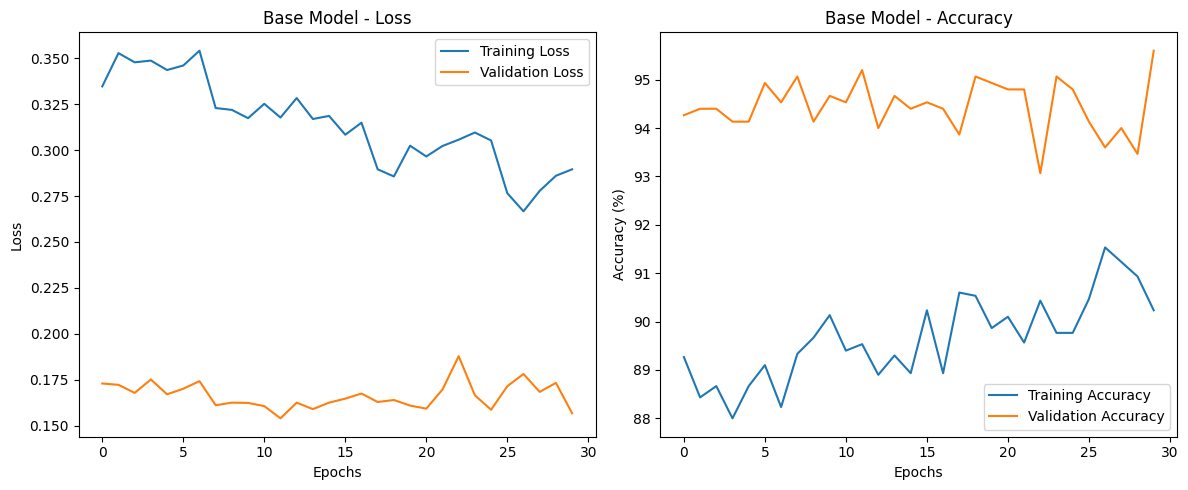

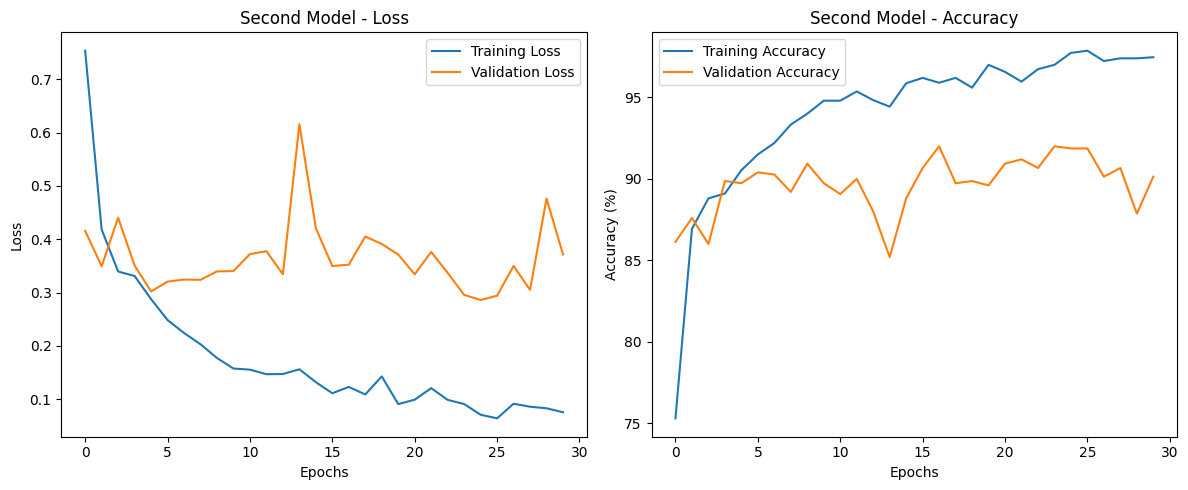

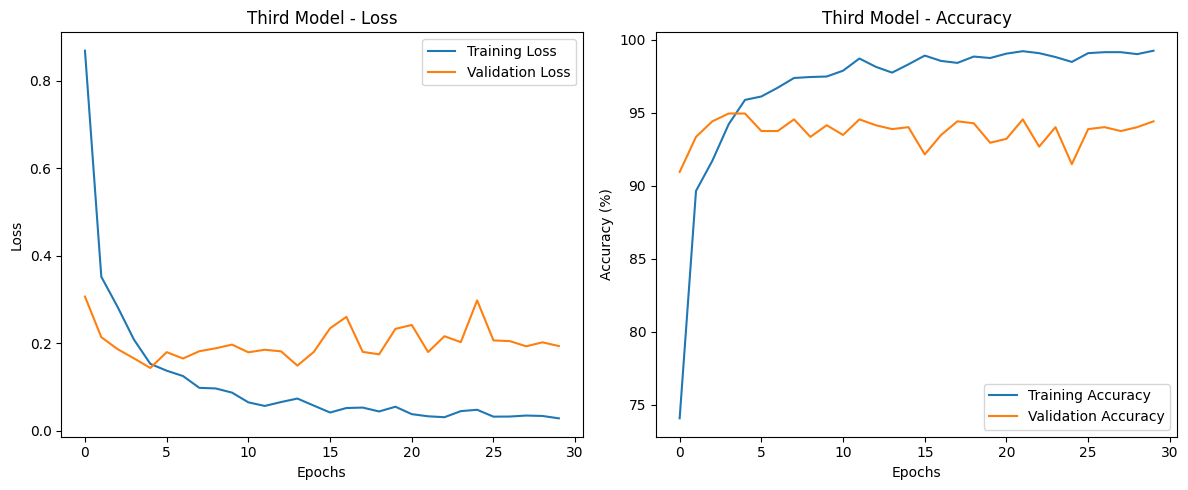

In [29]:
# Function to visualize results
def plot_results(train_results, model_name):
    train_losses, train_accuracies, val_losses, val_accuracies = train_results[:4]

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize results
plot_results(base_model_train_results, "Base Model")
plot_results(second_model_train_results, "Second Model")
plot_results(third_model_train_results, "Third Model")



* Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.

 Train only the final FC layer with frozen ResNet-18 weights: Loss and accuracy plots indicate a smooth convergence with minimal fluctuations. The validation accuracy (95.6%) was the highest among the models, showing strong generalization due to leveraging pre-trained features.

Unfreeze convolutional blocks 3 and 4, train with FC layer: The validation accuracy (92%) was slightly lower than the base model. Fine-tuning the deeper layers introduced some instability in validation loss due to additional parameters being trained. This model balances between task-specific learning and computational cost.

Unfreeze all layers and train the entire ResNet-18 model: The training loss decreases sharply, but validation loss fluctuates significantly, indicating overfitting. Validation accuracy (94.93%) was close to the second model but slightly less stable. This configuration demands large datasets and computational power to work effectively.

Best model: The base model generalizes better to unseen data compared to the second and third models. Its minimal validation loss fluctuations and highest validation accuracy (96%) suggest it as the most consistent performer.

* Which model performed better and why do you think it performed better?

The base model, where only the fully connected (FC) layer was trained while keeping ResNet-18 weights frozen, performed the best. By freezing most layers, it reduced overfitting and allowed the model to leverage robust pre-trained features. This resulted in the highest validation accuracy (96%) and smooth training behavior, making it effective for the given dataset.

* Comment on the practical considerations among these models also :

 Training only the FC layer with frozen ResNet-18 weights is fast and efficient since only the last layer is updated. It is well-suited for small datasets or when computational resources are limited, reducing the risk of overfitting while leveraging pre-trained features.
Unfreezing convolutional blocks 3 and 4 strikes a balance between pre-trained feature usage and task-specific learning. It is suitable for moderately sized datasets that benefit from limited fine-tuning.
Unfreezing all layers and training the entire model provides the most flexibility, fully adapting the model to the dataset. However, it carries a higher risk of overfitting, requires large datasets, and demands significant computational resources. It is best used when extensive fine-tuning is necessary and the dataset is large enough to support the additional complexity.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-30-2245a4562ae0>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

Evaluating the Best Model...
Accuracy: 93.60%
Classification Report:
              precision    recall  f1-score   support

        cane       0.84      0.95      0.89        75
     cavallo       0.94      0.87      0.90        75
    elefante       0.96      0.93      0.95        75
    farfalla       0.97      0.96      0.97        75
     gallina       1.00      0.99      0.99        75
       gatto       0.97      0.93      0.95        75
       mucca       0.80      0.93      0.86        75
      pecora       0.99      0.88      0.93        75
       ragno       0.96      0.96      0.96        75
  scoiattolo       0.97      0.96      0.97        75

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750



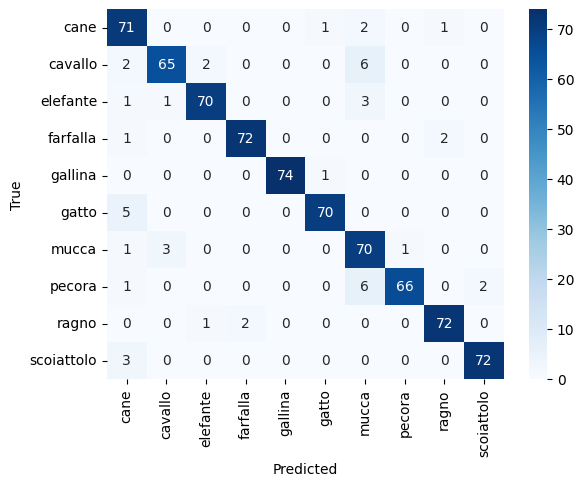

In [30]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to test the model and compute metrics
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

best_model_resnet = models.resnet18(pretrained=False)
best_model_resnet.fc = nn.Linear(best_model_resnet.fc.in_features, num_classes)
best_model_resnet.load_state_dict(torch.load(resnet18_best_model_path))
best_model_resnet = best_model_resnet.to(device)

  # Evaluate the best model
print("Evaluating the Best Model...")
best_model_preds, best_model_labels = test_model(best_model_resnet, test_loader, device)  # Replace `third_model` with the best-performing model

# Compute metrics
accuracy = np.mean(best_model_preds == best_model_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
class_report = classification_report(best_model_labels, best_model_preds, target_names=class_names)
print("Classification Report:")
print(class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(best_model_labels, best_model_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
 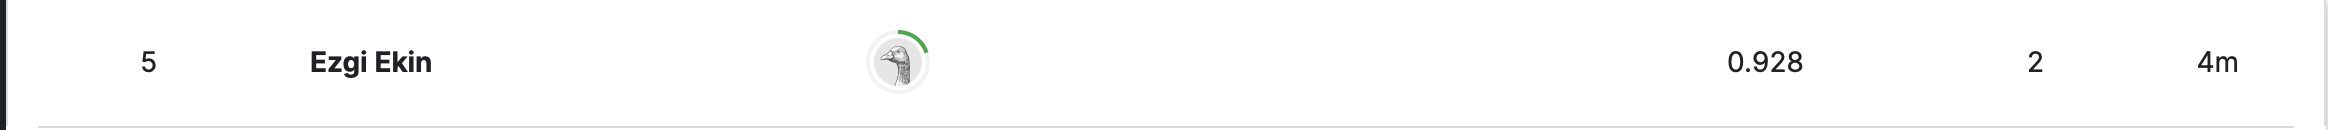
* High Accuracy: With a test accuracy of 92.8%, the model shows it can handle unseen data well, making it reliable for classification tasks. This highlights the effectiveness of using transfer learning with ResNet-18.
* Pretrained Advantage: Using ResNet-18's pretrained weights allowed the model to adapt quickly to the dataset without needing a lot of training. This approach works especially well for smaller or medium-sized datasets.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

### 2.7. Load the pre-trained MobileNet model (3 points)


In [31]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.
# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Check the model architecture
print(mobilenet)

# Ensure the architecture matches the standard MobileNetV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [32]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

# Load Pre-trained MobileNetV2 Model
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers of the MobileNet model
for param in mobilenet.parameters():
    param.requires_grad = False

num_classes = 10  # Animal-10 dataset has 10 classes
# Replace the final fully connected layer
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

# Unfreeze the final fully connected layer
for param in mobilenet.classifier[1].parameters():
    param.requires_grad = True

# Move the model to the appropriate device
mobilenet = mobilenet.to(device)

# Define the Loss Function and Optimizer
criterion_first = nn.CrossEntropyLoss()
optimizer_first = optim.Adam(mobilenet.classifier[1].parameters(), lr=0.001)



In [33]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the second MobileNet model
second_mobilenet = models.mobilenet_v2(pretrained=True)

# Replace the final fully connected (FC) layer to match the number of classes
num_classes = 10  # Update this based on the dataset's number of classes
second_mobilenet.classifier[1] = nn.Linear(second_mobilenet.last_channel, num_classes)

# Unfreeze all layers for training
for param in second_mobilenet.parameters():
    param.requires_grad = True

# Move the second model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
second_mobilenet = second_mobilenet.to(device)

# Define the loss function and optimizer
criterion_second = nn.CrossEntropyLoss()

# Use a smaller learning rate for fine-tuning the entire model
optimizer_second = optim.Adam(second_mobilenet.parameters(), lr=0.0001)



In [34]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

# Train models
best_accuracy = 0.0
print("Training Base Model...")
base_model_train_results = train_model(mobilenet, optimizer_first, criterion_first, train_loader, val_loader, 30, device, mobilenet_best_model_path)

print("Training Second Model...")
second_model_train_results = train_model(second_mobilenet, optimizer_second, criterion_second, train_loader, val_loader, 30, device, mobilenet_best_model_path)




Training Base Model...


Epoch 1/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


Epoch 1/30:
  Train Loss: 1.2077, Train Accuracy: 66.30%
  Val Loss: 0.4679, Val Accuracy: 92.53%


Epoch 2/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.72it/s]


Epoch 2/30:
  Train Loss: 0.6091, Train Accuracy: 83.40%
  Val Loss: 0.3156, Val Accuracy: 93.33%


Epoch 3/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


Epoch 3/30:
  Train Loss: 0.4959, Train Accuracy: 85.40%
  Val Loss: 0.2699, Val Accuracy: 93.33%


Epoch 4/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


Epoch 4/30:
  Train Loss: 0.4616, Train Accuracy: 86.37%
  Val Loss: 0.2292, Val Accuracy: 94.13%


Epoch 5/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


Epoch 5/30:
  Train Loss: 0.4206, Train Accuracy: 86.73%
  Val Loss: 0.2227, Val Accuracy: 95.07%


Epoch 6/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.55it/s]


Epoch 6/30:
  Train Loss: 0.4253, Train Accuracy: 86.03%
  Val Loss: 0.2025, Val Accuracy: 95.07%


Epoch 7/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


Epoch 7/30:
  Train Loss: 0.3904, Train Accuracy: 87.60%
  Val Loss: 0.2135, Val Accuracy: 94.13%


Epoch 8/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]


Epoch 8/30:
  Train Loss: 0.3795, Train Accuracy: 87.40%
  Val Loss: 0.1831, Val Accuracy: 95.33%


Epoch 9/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


Epoch 9/30:
  Train Loss: 0.3592, Train Accuracy: 88.90%
  Val Loss: 0.1822, Val Accuracy: 95.20%


Epoch 10/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.66it/s]


Epoch 10/30:
  Train Loss: 0.3809, Train Accuracy: 87.07%
  Val Loss: 0.1835, Val Accuracy: 95.07%


Epoch 11/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]


Epoch 11/30:
  Train Loss: 0.3723, Train Accuracy: 88.27%
  Val Loss: 0.1892, Val Accuracy: 94.27%


Epoch 12/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


Epoch 12/30:
  Train Loss: 0.3556, Train Accuracy: 88.30%
  Val Loss: 0.1753, Val Accuracy: 95.33%


Epoch 13/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.97it/s]


Epoch 13/30:
  Train Loss: 0.3394, Train Accuracy: 88.83%
  Val Loss: 0.1749, Val Accuracy: 95.33%


Epoch 14/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.73it/s]


Epoch 14/30:
  Train Loss: 0.3632, Train Accuracy: 88.43%
  Val Loss: 0.1735, Val Accuracy: 94.93%


Epoch 15/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.97it/s]


Epoch 15/30:
  Train Loss: 0.3405, Train Accuracy: 88.90%
  Val Loss: 0.1669, Val Accuracy: 95.33%


Epoch 16/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.97it/s]


Epoch 16/30:
  Train Loss: 0.3174, Train Accuracy: 89.47%
  Val Loss: 0.1763, Val Accuracy: 95.20%


Epoch 17/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.95it/s]


Epoch 17/30:
  Train Loss: 0.3341, Train Accuracy: 88.63%
  Val Loss: 0.1835, Val Accuracy: 95.07%


Epoch 18/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.76it/s]


Epoch 18/30:
  Train Loss: 0.3188, Train Accuracy: 89.57%
  Val Loss: 0.1714, Val Accuracy: 95.60%


Epoch 19/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch 19/30:
  Train Loss: 0.3402, Train Accuracy: 89.00%
  Val Loss: 0.1743, Val Accuracy: 94.27%


Epoch 20/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]


Epoch 20/30:
  Train Loss: 0.3338, Train Accuracy: 88.80%
  Val Loss: 0.1666, Val Accuracy: 95.73%


Epoch 21/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


Epoch 21/30:
  Train Loss: 0.3404, Train Accuracy: 88.00%
  Val Loss: 0.1729, Val Accuracy: 94.53%


Epoch 22/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.55it/s]


Epoch 22/30:
  Train Loss: 0.3024, Train Accuracy: 89.87%
  Val Loss: 0.1683, Val Accuracy: 95.07%


Epoch 23/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.08it/s]


Epoch 23/30:
  Train Loss: 0.3134, Train Accuracy: 89.33%
  Val Loss: 0.1649, Val Accuracy: 94.93%


Epoch 24/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.05it/s]


Epoch 24/30:
  Train Loss: 0.3195, Train Accuracy: 89.20%
  Val Loss: 0.1800, Val Accuracy: 94.27%


Epoch 25/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch 25/30:
  Train Loss: 0.3060, Train Accuracy: 89.27%
  Val Loss: 0.1753, Val Accuracy: 95.73%


Epoch 26/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.69it/s]


Epoch 26/30:
  Train Loss: 0.3146, Train Accuracy: 89.33%
  Val Loss: 0.1673, Val Accuracy: 94.93%


Epoch 27/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]


Epoch 27/30:
  Train Loss: 0.3086, Train Accuracy: 89.23%
  Val Loss: 0.1779, Val Accuracy: 95.20%


Epoch 28/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.87it/s]


Epoch 28/30:
  Train Loss: 0.3062, Train Accuracy: 89.93%
  Val Loss: 0.1799, Val Accuracy: 94.80%


Epoch 29/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


Epoch 29/30:
  Train Loss: 0.2950, Train Accuracy: 90.13%
  Val Loss: 0.1724, Val Accuracy: 95.20%


Epoch 30/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.50it/s]


Epoch 30/30:
  Train Loss: 0.3041, Train Accuracy: 89.90%
  Val Loss: 0.1823, Val Accuracy: 94.93%
Training Second Model...


Epoch 1/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]


Epoch 1/30:
  Train Loss: 1.0465, Train Accuracy: 70.07%
  Val Loss: 0.3083, Val Accuracy: 92.13%


Epoch 2/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


Epoch 2/30:
  Train Loss: 0.4112, Train Accuracy: 87.70%
  Val Loss: 0.2195, Val Accuracy: 93.07%


Epoch 3/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.21it/s]


Epoch 3/30:
  Train Loss: 0.2792, Train Accuracy: 92.23%
  Val Loss: 0.1771, Val Accuracy: 95.20%


Epoch 4/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.72it/s]


Epoch 4/30:
  Train Loss: 0.2143, Train Accuracy: 94.17%
  Val Loss: 0.1848, Val Accuracy: 94.40%


Epoch 5/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]


Epoch 5/30:
  Train Loss: 0.1771, Train Accuracy: 94.73%
  Val Loss: 0.1939, Val Accuracy: 93.87%


Epoch 6/30 - Validation:  79%|███████▉  | 15/19 [00:02<00:00, 12.50it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e54d9723d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e54d9723d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py"

Epoch 6/30:
  Train Loss: 0.1628, Train Accuracy: 95.07%
  Val Loss: 0.1513, Val Accuracy: 95.33%


Epoch 7/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


Epoch 7/30:
  Train Loss: 0.1301, Train Accuracy: 96.33%
  Val Loss: 0.1512, Val Accuracy: 95.47%


Epoch 8/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.51it/s]


Epoch 8/30:
  Train Loss: 0.1186, Train Accuracy: 95.90%
  Val Loss: 0.1473, Val Accuracy: 95.73%


Epoch 9/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.85it/s]


Epoch 9/30:
  Train Loss: 0.0915, Train Accuracy: 97.43%
  Val Loss: 0.1418, Val Accuracy: 95.87%


Epoch 10/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


Epoch 10/30:
  Train Loss: 0.0777, Train Accuracy: 98.00%
  Val Loss: 0.1406, Val Accuracy: 95.47%


Epoch 11/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]


Epoch 11/30:
  Train Loss: 0.0882, Train Accuracy: 97.27%
  Val Loss: 0.1582, Val Accuracy: 94.27%


Epoch 12/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.68it/s]


Epoch 12/30:
  Train Loss: 0.0665, Train Accuracy: 98.13%
  Val Loss: 0.1517, Val Accuracy: 95.73%


Epoch 13/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.86it/s]


Epoch 13/30:
  Train Loss: 0.0639, Train Accuracy: 97.80%
  Val Loss: 0.1630, Val Accuracy: 94.93%


Epoch 14/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.89it/s]


Epoch 14/30:
  Train Loss: 0.0643, Train Accuracy: 98.03%
  Val Loss: 0.1503, Val Accuracy: 95.60%


Epoch 15/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.90it/s]


Epoch 15/30:
  Train Loss: 0.0597, Train Accuracy: 98.33%
  Val Loss: 0.1827, Val Accuracy: 94.93%


Epoch 16/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.57it/s]


Epoch 16/30:
  Train Loss: 0.0777, Train Accuracy: 97.67%
  Val Loss: 0.1716, Val Accuracy: 95.20%


Epoch 17/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.84it/s]


Epoch 17/30:
  Train Loss: 0.0532, Train Accuracy: 98.60%
  Val Loss: 0.1560, Val Accuracy: 95.33%


Epoch 18/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.26it/s]


Epoch 18/30:
  Train Loss: 0.0392, Train Accuracy: 98.90%
  Val Loss: 0.1424, Val Accuracy: 95.47%


Epoch 19/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


Epoch 19/30:
  Train Loss: 0.0369, Train Accuracy: 98.97%
  Val Loss: 0.1624, Val Accuracy: 95.47%


Epoch 20/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.81it/s]


Epoch 20/30:
  Train Loss: 0.0507, Train Accuracy: 98.50%
  Val Loss: 0.2148, Val Accuracy: 93.87%


Epoch 21/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


Epoch 21/30:
  Train Loss: 0.0478, Train Accuracy: 98.43%
  Val Loss: 0.1693, Val Accuracy: 94.93%


Epoch 22/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]


Epoch 22/30:
  Train Loss: 0.0426, Train Accuracy: 98.70%
  Val Loss: 0.2174, Val Accuracy: 94.13%


Epoch 23/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


Epoch 23/30:
  Train Loss: 0.0457, Train Accuracy: 98.43%
  Val Loss: 0.1694, Val Accuracy: 95.73%


Epoch 24/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.52it/s]


Epoch 24/30:
  Train Loss: 0.0367, Train Accuracy: 99.03%
  Val Loss: 0.1781, Val Accuracy: 95.33%


Epoch 25/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.90it/s]


Epoch 25/30:
  Train Loss: 0.0354, Train Accuracy: 99.00%
  Val Loss: 0.1938, Val Accuracy: 94.93%


Epoch 26/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.87it/s]


Epoch 26/30:
  Train Loss: 0.0393, Train Accuracy: 98.77%
  Val Loss: 0.1936, Val Accuracy: 94.40%


Epoch 27/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


Epoch 27/30:
  Train Loss: 0.0417, Train Accuracy: 98.60%
  Val Loss: 0.2042, Val Accuracy: 94.40%


Epoch 28/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.62it/s]


Epoch 28/30:
  Train Loss: 0.0371, Train Accuracy: 98.80%
  Val Loss: 0.1679, Val Accuracy: 95.20%


Epoch 29/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.74it/s]


Epoch 29/30:
  Train Loss: 0.0316, Train Accuracy: 99.00%
  Val Loss: 0.1809, Val Accuracy: 94.67%


Epoch 30/30 - Validation: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]

Epoch 30/30:
  Train Loss: 0.0296, Train Accuracy: 99.03%
  Val Loss: 0.1689, Val Accuracy: 95.07%


In [35]:

print(base_model_train_results[5])
print(second_model_train_results[5])

95.73333333333333
95.86666666666666


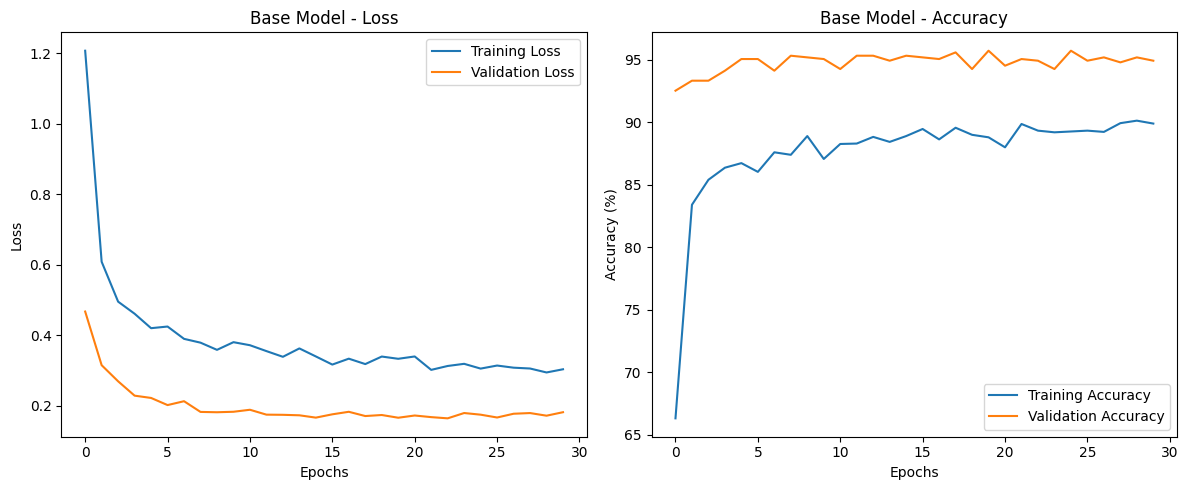

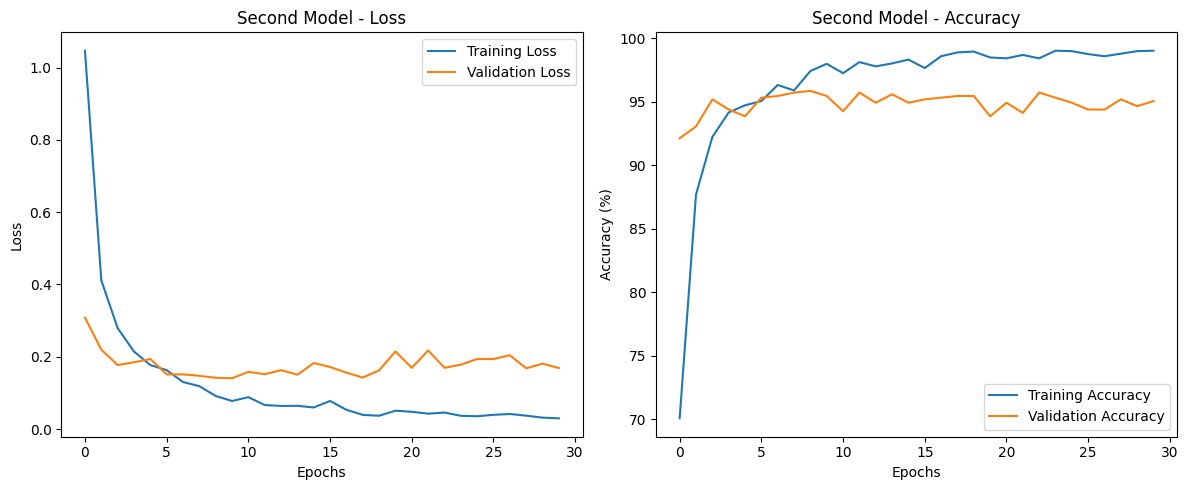

In [36]:
# Visualize results
plot_results(base_model_train_results, "Base Model")
plot_results(second_model_train_results, "Second Model")

* Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy :

Train only the final FC layer with frozen MobileNet weights: The validation accuracy reached 95.73%, with smooth convergence in both training and validation loss. Freezing most of the MobileNet layers allowed it to efficiently leverage pre-trained features, leading to consistent generalization on unseen data with minimal fluctuations.

Train the entire MobileNet network by unfreezing all layers: The validation accuracy was 95.86%, slightly better than the base model. However, unfreezing all layers increased the complexity of training, introducing some fluctuations in the validation loss, indicating potential overfitting to the training data.

Best model: The second model slightly outperformed the base model with a higher validation accuracy (95.86%). However, the difference is marginal, and the base model remains a strong candidate for scenarios requiring computational efficiency.

* Which model performed better and why do you think it performed better?
  
  The second model, where the entire MobileNet was trained by unfreezing all layers, performed slightly better, achieving a marginally higher validation accuracy (95.86%). This is likely because unfreezing all layers allowed the model to fine-tune features at all levels, adapting more specifically to the dataset. However, the improvement over the base model is minimal, suggesting that the pre-trained features of MobileNet are already well-suited for the task.
  
* Comment on the practical considerations among these models also :

Training only the final FC layer with frozen MobileNet weights is computationally efficient and suitable for smaller datasets. This approach minimizes overfitting risks and leverages the robust pre-trained features of MobileNet effectively, making it ideal for limited computational resources.

Unfreezing all layers of MobileNet allows the model to fully adapt to the dataset, making it suitable for larger and more complex datasets. However, this approach is computationally expensive and can lead to overfitting, particularly if the dataset size is not large enough to support the increased complexity.

For most practical purposes, the base model offers a strong balance of efficiency and performance. The second model is advantageous when computational resources and dataset size are sufficient to justify the added training complexity.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

Evaluating the Best Model...


<ipython-input-37-60bb4b908fd3>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_mobile.load_state_dict(torch.load(mobilenet_best_model_path))


Accuracy: 96.27%
Classification Report:
              precision    recall  f1-score   support

        cane       0.92      0.96      0.94        75
     cavallo       0.95      0.93      0.94        75
    elefante       0.97      0.97      0.97        75
    farfalla       0.96      0.97      0.97        75
     gallina       1.00      0.96      0.98        75
       gatto       0.99      0.99      0.99        75
       mucca       0.94      0.96      0.95        75
      pecora       0.99      0.96      0.97        75
       ragno       0.96      0.97      0.97        75
  scoiattolo       0.96      0.95      0.95        75

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



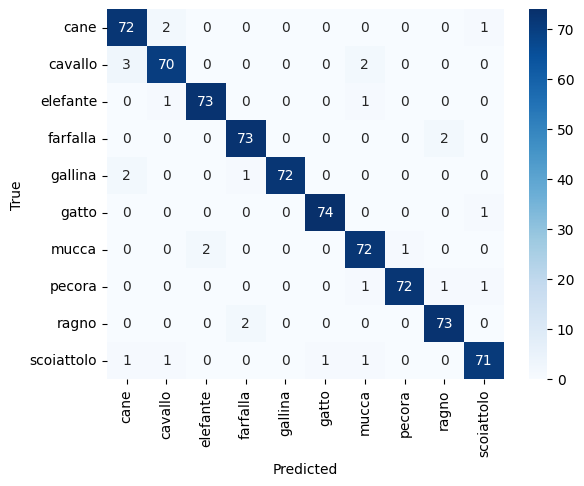

In [37]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
# Load the MobileNetV2 model
best_model_mobile = mobilenet_v2(weights=None)  # Use None for a model without pre-trained weights

# Replace the final layer in the classifier to match the number of classes
best_model_mobile.classifier[1] = nn.Linear(best_model_mobile.last_channel, num_classes)

# Load the saved state dict for the best model
best_model_mobile.load_state_dict(torch.load(mobilenet_best_model_path))

# Move the model to the appropriate device
best_model_mobile = best_model_mobile.to(device)

  # Evaluate the best model
print("Evaluating the Best Model...")
best_model_preds, best_model_labels = test_model(best_model_mobile, test_loader, device)  # Replace `third_model` with the best-performing model

# Compute metrics
accuracy = np.mean(best_model_preds == best_model_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
class_report = classification_report(best_model_labels, best_model_preds, target_names=class_names)
print("Classification Report:")
print(class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(best_model_labels, best_model_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

MobileNet Classification Report:
               precision    recall  f1-score   support

        cane       0.92      0.96      0.94        75
     cavallo       0.95      0.93      0.94        75
    elefante       0.97      0.97      0.97        75
    farfalla       0.96      0.97      0.97        75
     gallina       1.00      0.96      0.98        75
       gatto       0.99      0.99      0.99        75
       mucca       0.94      0.96      0.95        75
      pecora       0.99      0.96      0.97        75
       ragno       0.96      0.97      0.97        75
  scoiattolo       0.96      0.95      0.95        75

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750

ResNet18 Classification Report:
               precision    recall  f1-score   support

        cane       0.84      0.95      0.89        75
     cavallo       0.94      0.87      0.90        75
    elefant

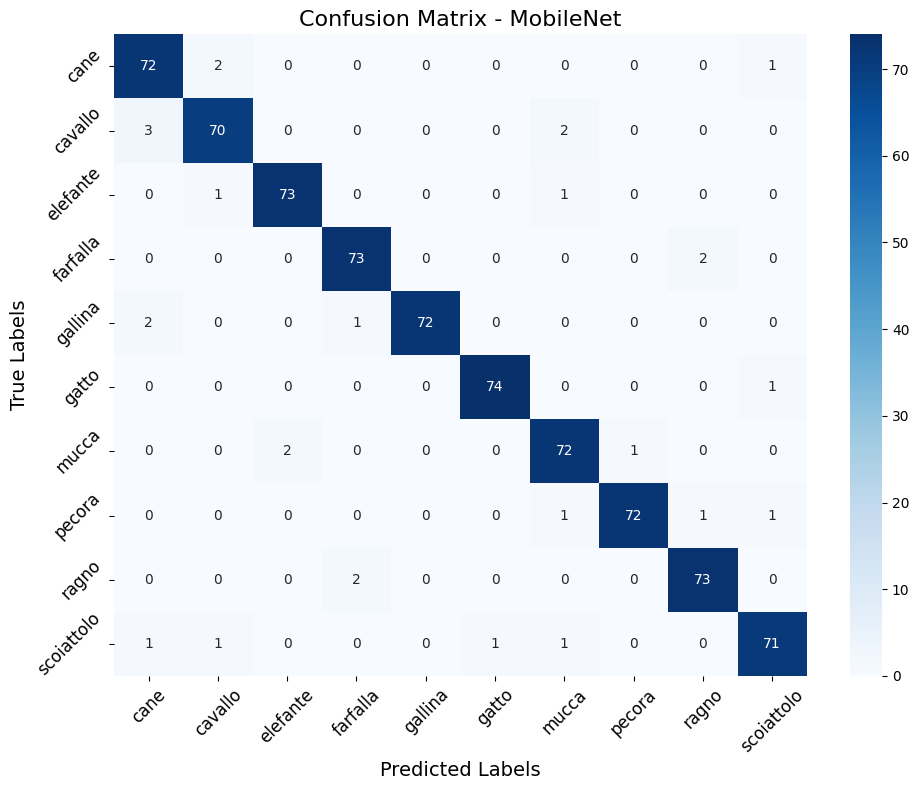

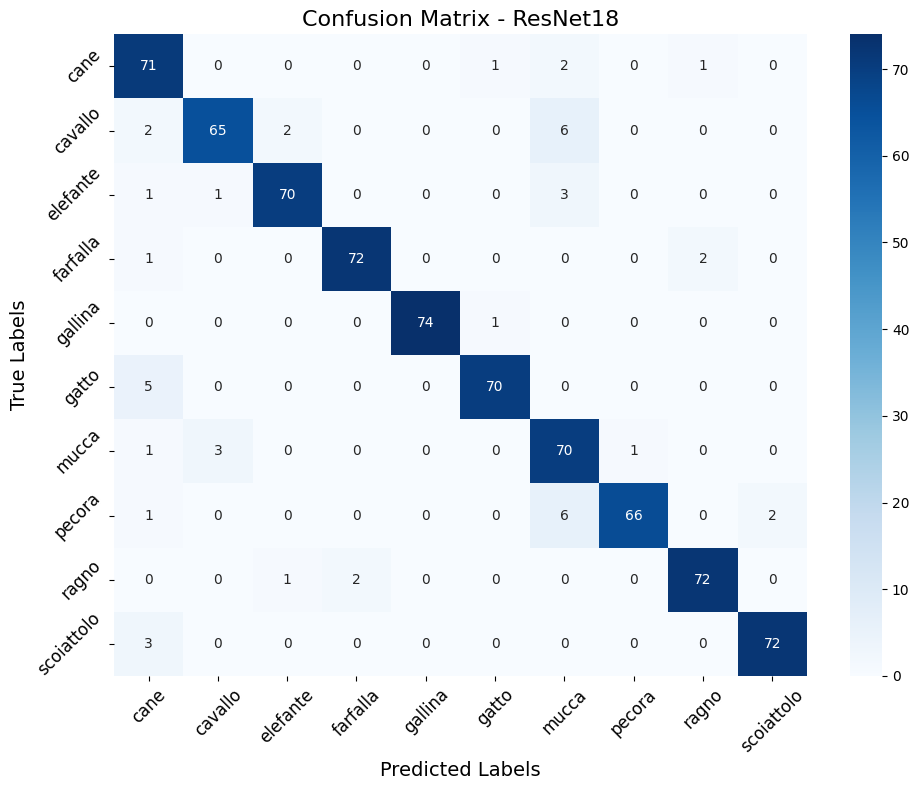

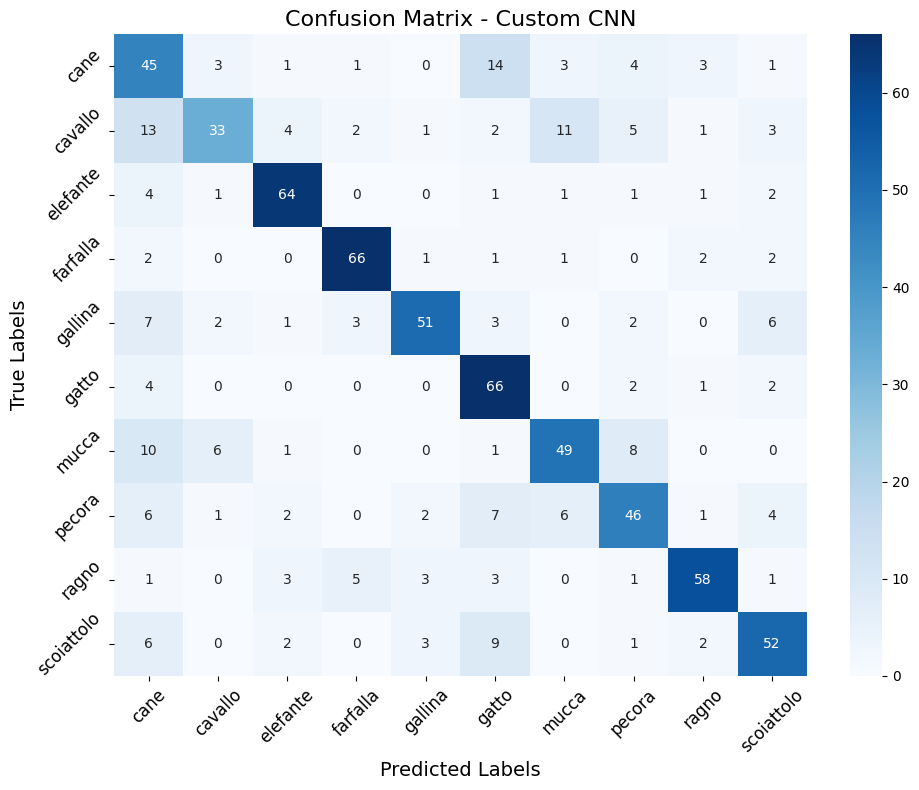

In [38]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    return accuracy, np.array(all_preds), np.array(all_labels)

# Evaluate the MobileNet model
mobilenet_accuracy, mobilenet_preds, mobilenet_labels = evaluate_model(best_model_mobile, test_loader, device)

# Evaluate the ResNet18 model
resnet18_accuracy, resnet18_preds, resnet18_labels = evaluate_model(best_model_resnet, test_loader, device)

# Evaluate the Custom CNN model
cnn_accuracy, cnn_preds, cnn_labels = evaluate_model(cnn_best, test_loader, device)


# Compute metrics for each model
mobilenet_report = classification_report(mobilenet_labels, mobilenet_preds, target_names=class_names)
resnet18_report = classification_report(resnet18_labels, resnet18_preds, target_names=class_names)
cnn_report = classification_report(cnn_labels, cnn_preds, target_names=class_names)

# Compute confusion matrices
mobilenet_conf_matrix = confusion_matrix(mobilenet_labels, mobilenet_preds)
resnet18_conf_matrix = confusion_matrix(resnet18_labels, resnet18_preds)
cnn_conf_matrix = confusion_matrix(cnn_labels, cnn_preds)

# Display classification reports
print("MobileNet Classification Report:\n", mobilenet_report)
print("ResNet18 Classification Report:\n", resnet18_report)
print("Custom CNN Classification Report:\n", cnn_report)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, model_name, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=45, fontsize=12)
    plt.tight_layout()  # Ensures everything fits well
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(mobilenet_conf_matrix, "MobileNet",class_names)
plot_confusion_matrix(resnet18_conf_matrix, "ResNet18",class_names)
plot_confusion_matrix(cnn_conf_matrix, "Custom CNN",class_names)


* MobileNet vs CNN :

  MobileNet achieved 96% accuracy, significantly outperforming the Custom CNN, which only reached 71%. This difference is attributed to MobileNet's pre-trained architecture and optimized feature extraction, whereas the Custom CNN relies solely on task-specific training, which limits its performance. Additionally, MobileNet is computationally efficient and lightweight, making it more practical for real-world deployment, whereas the Custom CNN is resource-intensive and less effective.

* MobileNet vs Resnet18 :

  MobileNet achieved 96% accuracy, slightly higher than ResNet18's 94%. It also outperformed ResNet18 in macro averages for precision, recall, and F1-score, recording 96% compared to ResNet18's 94%. While both models leverage pre-trained architectures and are highly effective, MobileNet's lightweight design gives it an edge in resource-constrained environments, such as mobile or real-time applications. In contrast, ResNet18 requires more computational resources due to its deeper architecture, making it better suited for tasks that demand extensive feature extraction on larger datasets.

  

### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
  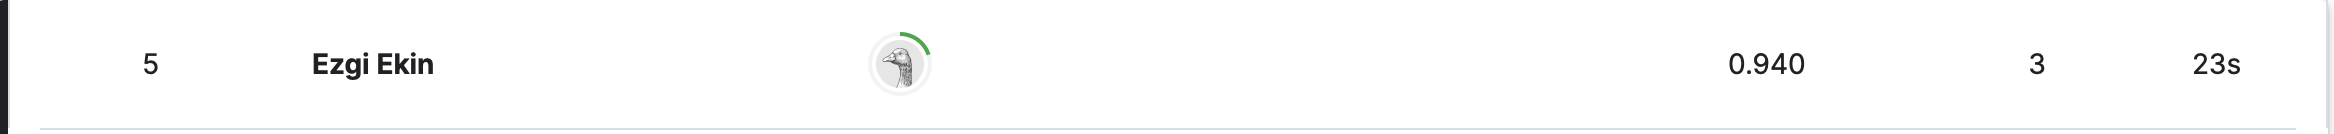
* High Accuracy: With a test accuracy of 94%, the model demonstrates strong performance on unseen data, making it highly reliable for classification tasks. This showcases the effectiveness of transfer learning with MobileNet.
* Pretrained Advantage: Leveraging MobileNet's pretrained weights enabled the model to adapt quickly to the dataset without requiring extensive training. This approach is particularly effective for smaller to medium-sized datasets, balancing efficiency and accuracy.
*
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch :
* Why Transfer Learning is Great
Transfer learning saves time by reusing a pre-trained model instead of starting from scratch. It works well even with smaller datasets, as pre-trained models already "know" common features from large datasets.

* But It’s Not Perfect
Transfer learning gives less control than training from scratch. If data is very different from what the pre-trained model was built on, performance might drop. Also, if there’s no pre-trained model for the problem, it won’t be an option.

* Why Training from Scratch Is Tough
Training from scratch is slow and needs a lot of data and computing power. Without these, model may overfit or struggle to learn. Plus, tuning everything can feel never-ending.

* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)


In [4]:
import pandas as pd
data = {
    "Model": ["Custom CNN", "ResNet18", "MobileNet"],
    "Accuracy": [0.71, 0.94, 0.96],
    "Macro Avg Precision": [0.72, 0.94, 0.96],
    "Macro Avg Recall": [0.71, 0.94, 0.96],
    "Macro Avg F1-Score": [0.71, 0.94, 0.96]
}

# Create a DataFrame
df = pd.DataFrame(data)

df

,Model,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score
0,Custom CNN,0.71,0.72,0.71,0.71
1,ResNet18,0.94,0.94,0.94,0.94
2,MobileNet,0.96,0.96,0.96,0.96


 * Discuss practical considerations when choosing between these approaches and models.

Custom CNN offers full control and is useful for unique tasks but requires large datasets and significant computational power. It’s slow to train and, with only 71% accuracy, isn’t ideal for general tasks or scenarios where high precision is needed.

ResNet18 provides 94% accuracy and strong generalization, making it an excellent choice for tasks requiring a balance of precision and generalization. However, it demands more resources and is less efficient than MobileNet, particularly for real-time applications.

MobileNet achieves the highest accuracy (96%) while maintaining efficiency, making it a great choice for resource-limited environments like mobile or real-time applications. Its lightweight design is ideal for deployment scenarios but may slightly lack the generalization power of ResNet18 in very specific tasks.

In summary, choose ResNet18 for balanced generalization and precision, MobileNet for efficiency and high accuracy, and Custom CNN only for specialized tasks requiring model customization despite its lower accuracy.